### 0 - Libraries

In [1]:
import pandas as pd
import numpy as np

from collections import Counter
import random

import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.spatial.distance import mahalanobis
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

### 1 - Set random seed

In [2]:
# Set the random state
random_state = min(332078,332464)
random.seed(random_state)

### 2 - Dataset

In [3]:
# Import the dataset
df_dev = pd.read_csv('development.csv')

In [4]:
# Shape
df_dev.shape

(385500, 92)

In [5]:
# Columns
df_dev.columns

Index(['x', 'y', 'pmax[0]', 'negpmax[0]', 'area[0]', 'tmax[0]', 'rms[0]',
       'pmax[1]', 'negpmax[1]', 'area[1]', 'tmax[1]', 'rms[1]', 'pmax[2]',
       'negpmax[2]', 'area[2]', 'tmax[2]', 'rms[2]', 'pmax[3]', 'negpmax[3]',
       'area[3]', 'tmax[3]', 'rms[3]', 'pmax[4]', 'negpmax[4]', 'area[4]',
       'tmax[4]', 'rms[4]', 'pmax[5]', 'negpmax[5]', 'area[5]', 'tmax[5]',
       'rms[5]', 'pmax[6]', 'negpmax[6]', 'area[6]', 'tmax[6]', 'rms[6]',
       'pmax[7]', 'negpmax[7]', 'area[7]', 'tmax[7]', 'rms[7]', 'pmax[8]',
       'negpmax[8]', 'area[8]', 'tmax[8]', 'rms[8]', 'pmax[9]', 'negpmax[9]',
       'area[9]', 'tmax[9]', 'rms[9]', 'pmax[10]', 'negpmax[10]', 'area[10]',
       'tmax[10]', 'rms[10]', 'pmax[11]', 'negpmax[11]', 'area[11]',
       'tmax[11]', 'rms[11]', 'pmax[12]', 'negpmax[12]', 'area[12]',
       'tmax[12]', 'rms[12]', 'pmax[13]', 'negpmax[13]', 'area[13]',
       'tmax[13]', 'rms[13]', 'pmax[14]', 'negpmax[14]', 'area[14]',
       'tmax[14]', 'rms[14]', 'pmax[15]', 

1) x, y: the position of the events over the sensor
2) pmax[0], pmax[1], ... pmax[17]: the magnitude of the positive peak of the signal, in mV
3) negpmax[0], negpmax[1], ... negpmax[17]: the magnitude of the negative peak of the signal, in mV
4) tmax[0], tmax[1], ... tmax[17]: the delay (in ns) from a reference time when the positive peak of the signal
5) area[0], area[1], ... area[17]: the area under the signal
6) rms[0], rms[1], ... rms[17]: the root mean square (RMS) value of the signal

In [6]:
# NaN values
display(df_dev.isna().any())
print(f'\nThe dataset has {df_dev.isna().any().sum()} NaN values')

x              False
y              False
pmax[0]        False
negpmax[0]     False
area[0]        False
               ...  
pmax[17]       False
negpmax[17]    False
area[17]       False
tmax[17]       False
rms[17]        False
Length: 92, dtype: bool


The dataset has 0 NaN values


### 3 - Data visualization

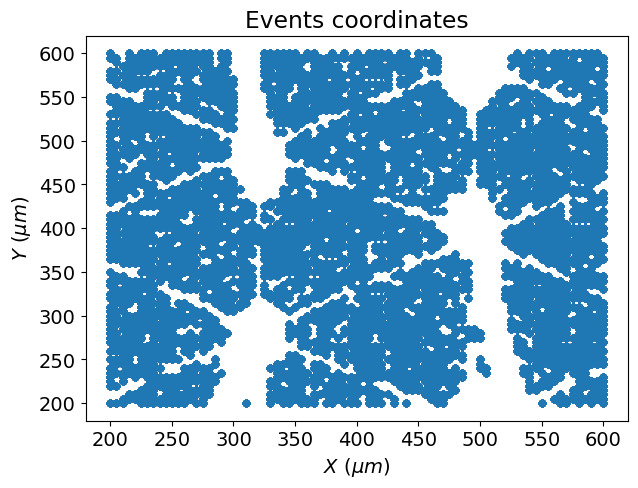

In [7]:
# Scatter plot of x and y
mpl.rcParams["font.size"] = 14
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(df_dev['x'], df_dev['y'], s=20, alpha=0.5, marker='8')
ax.set_title('Events coordinates')
ax.set_xlabel('$X$ ($\\mu m$)')
ax.set_ylabel('$Y$ ($\\mu m$)')

plt.show()

Some areas of the sensor are not covered by any event. That occurs because, at those coordinates, either pads or wires used to read the signals from the pads (due to their reflective properties) are presen

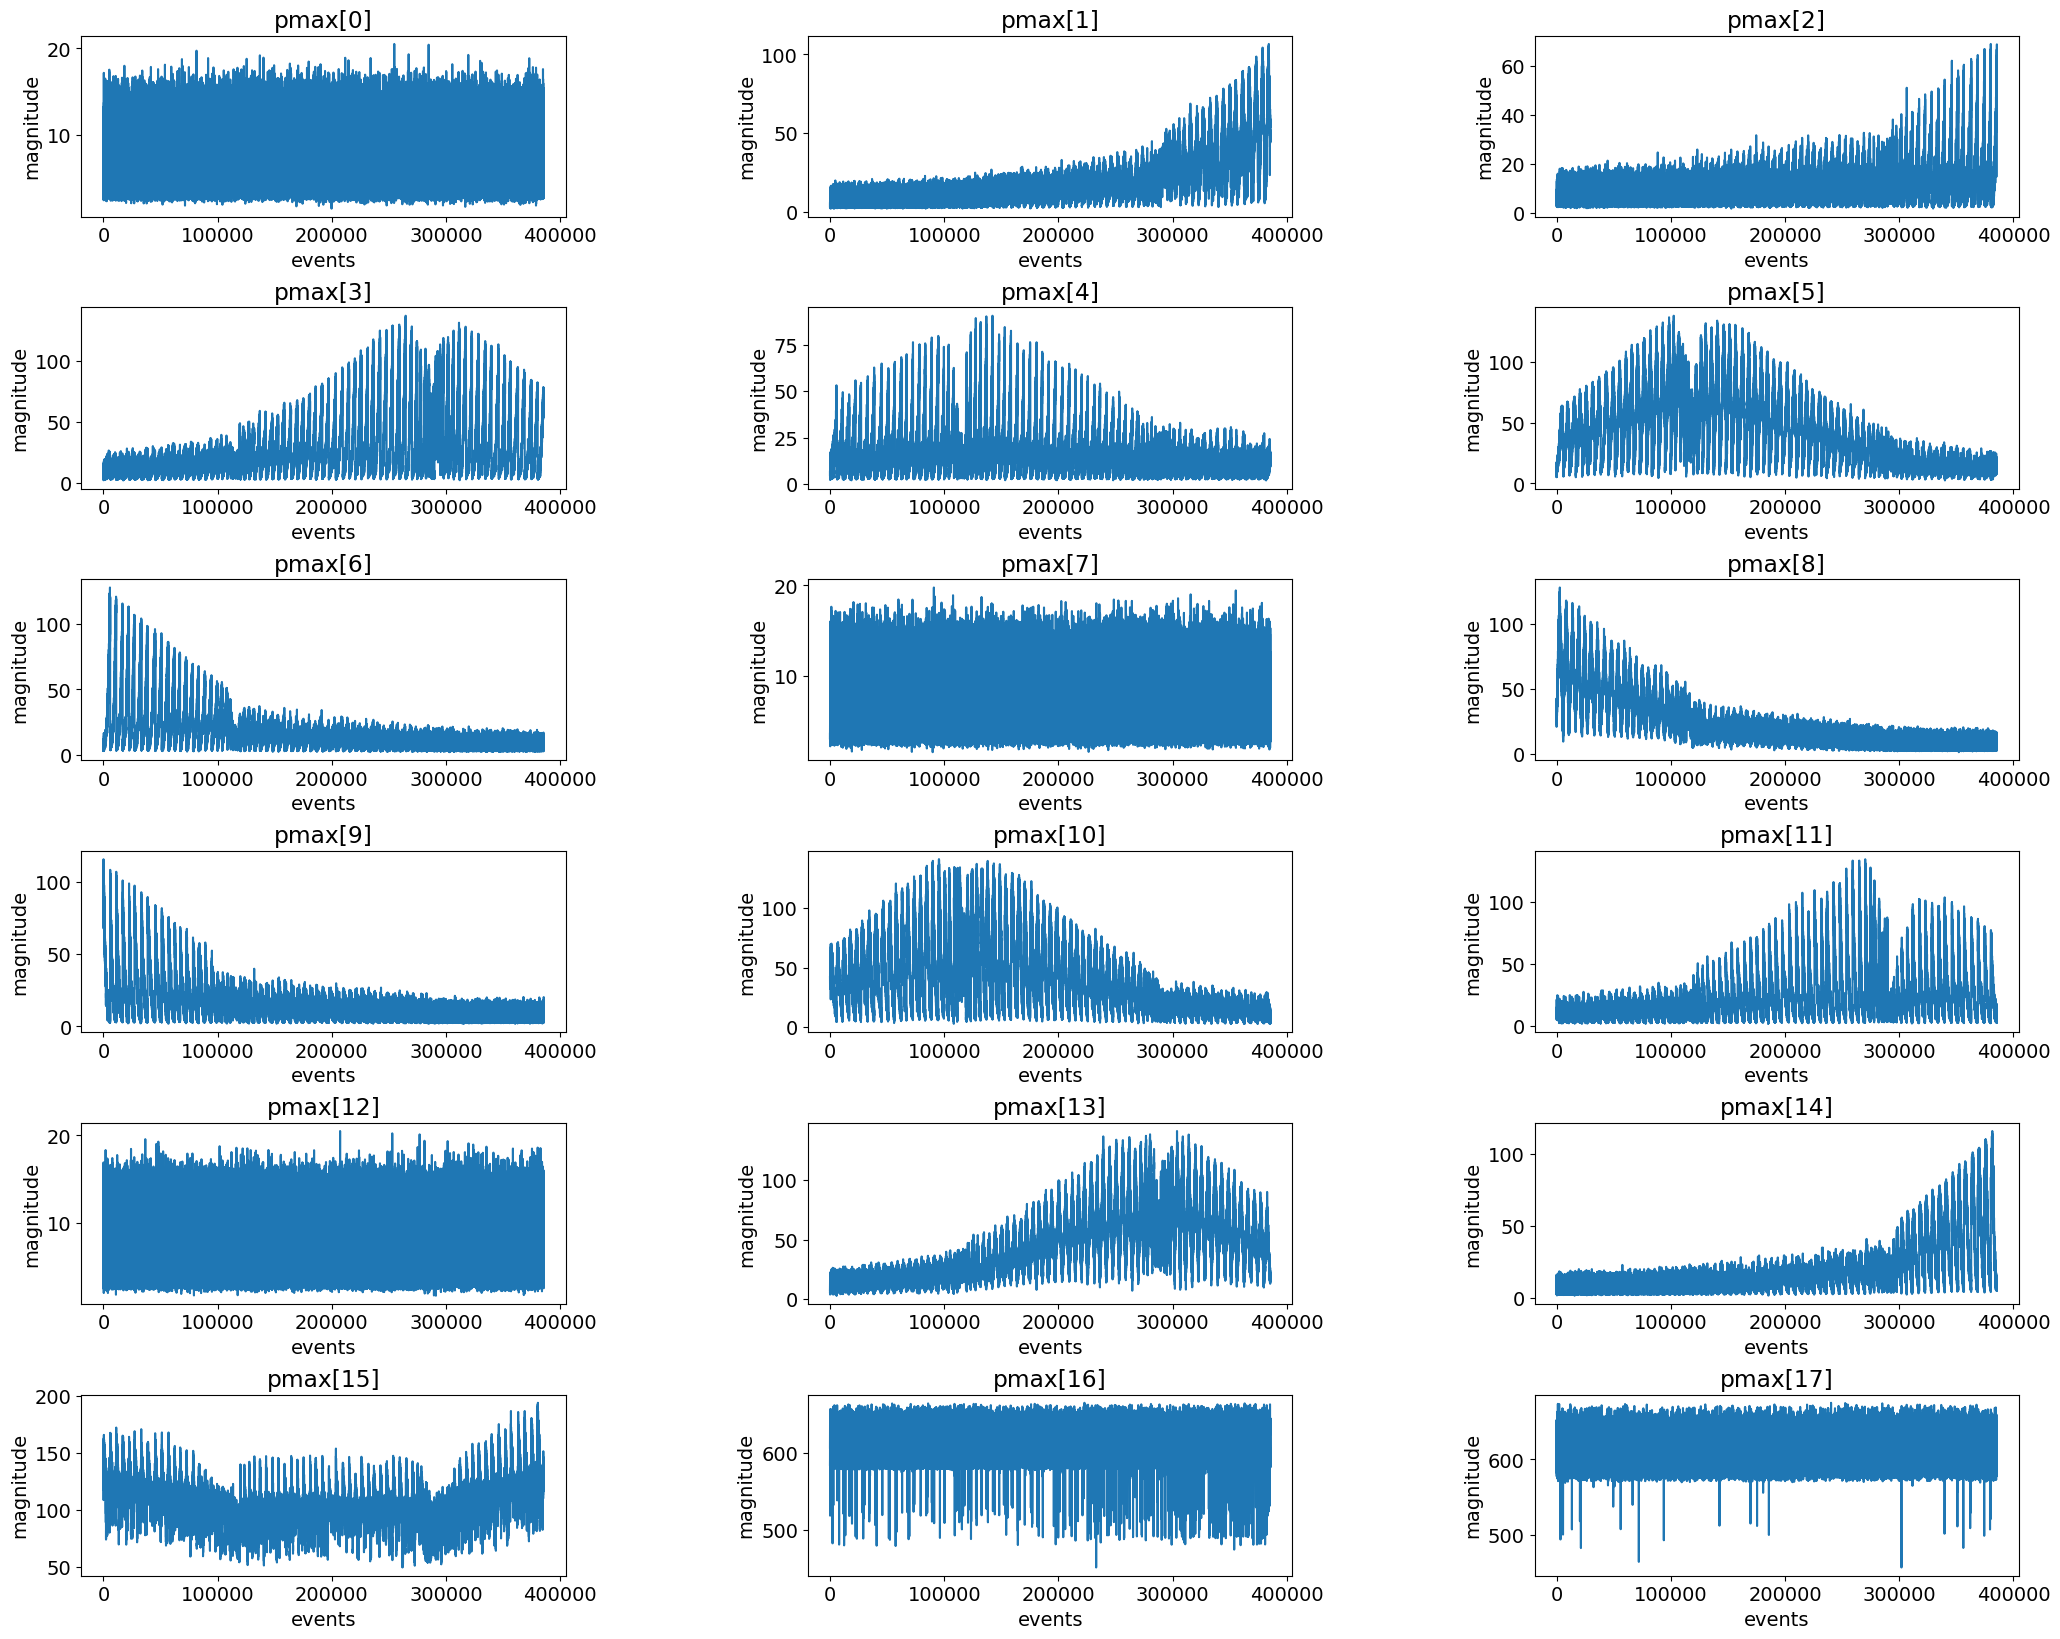

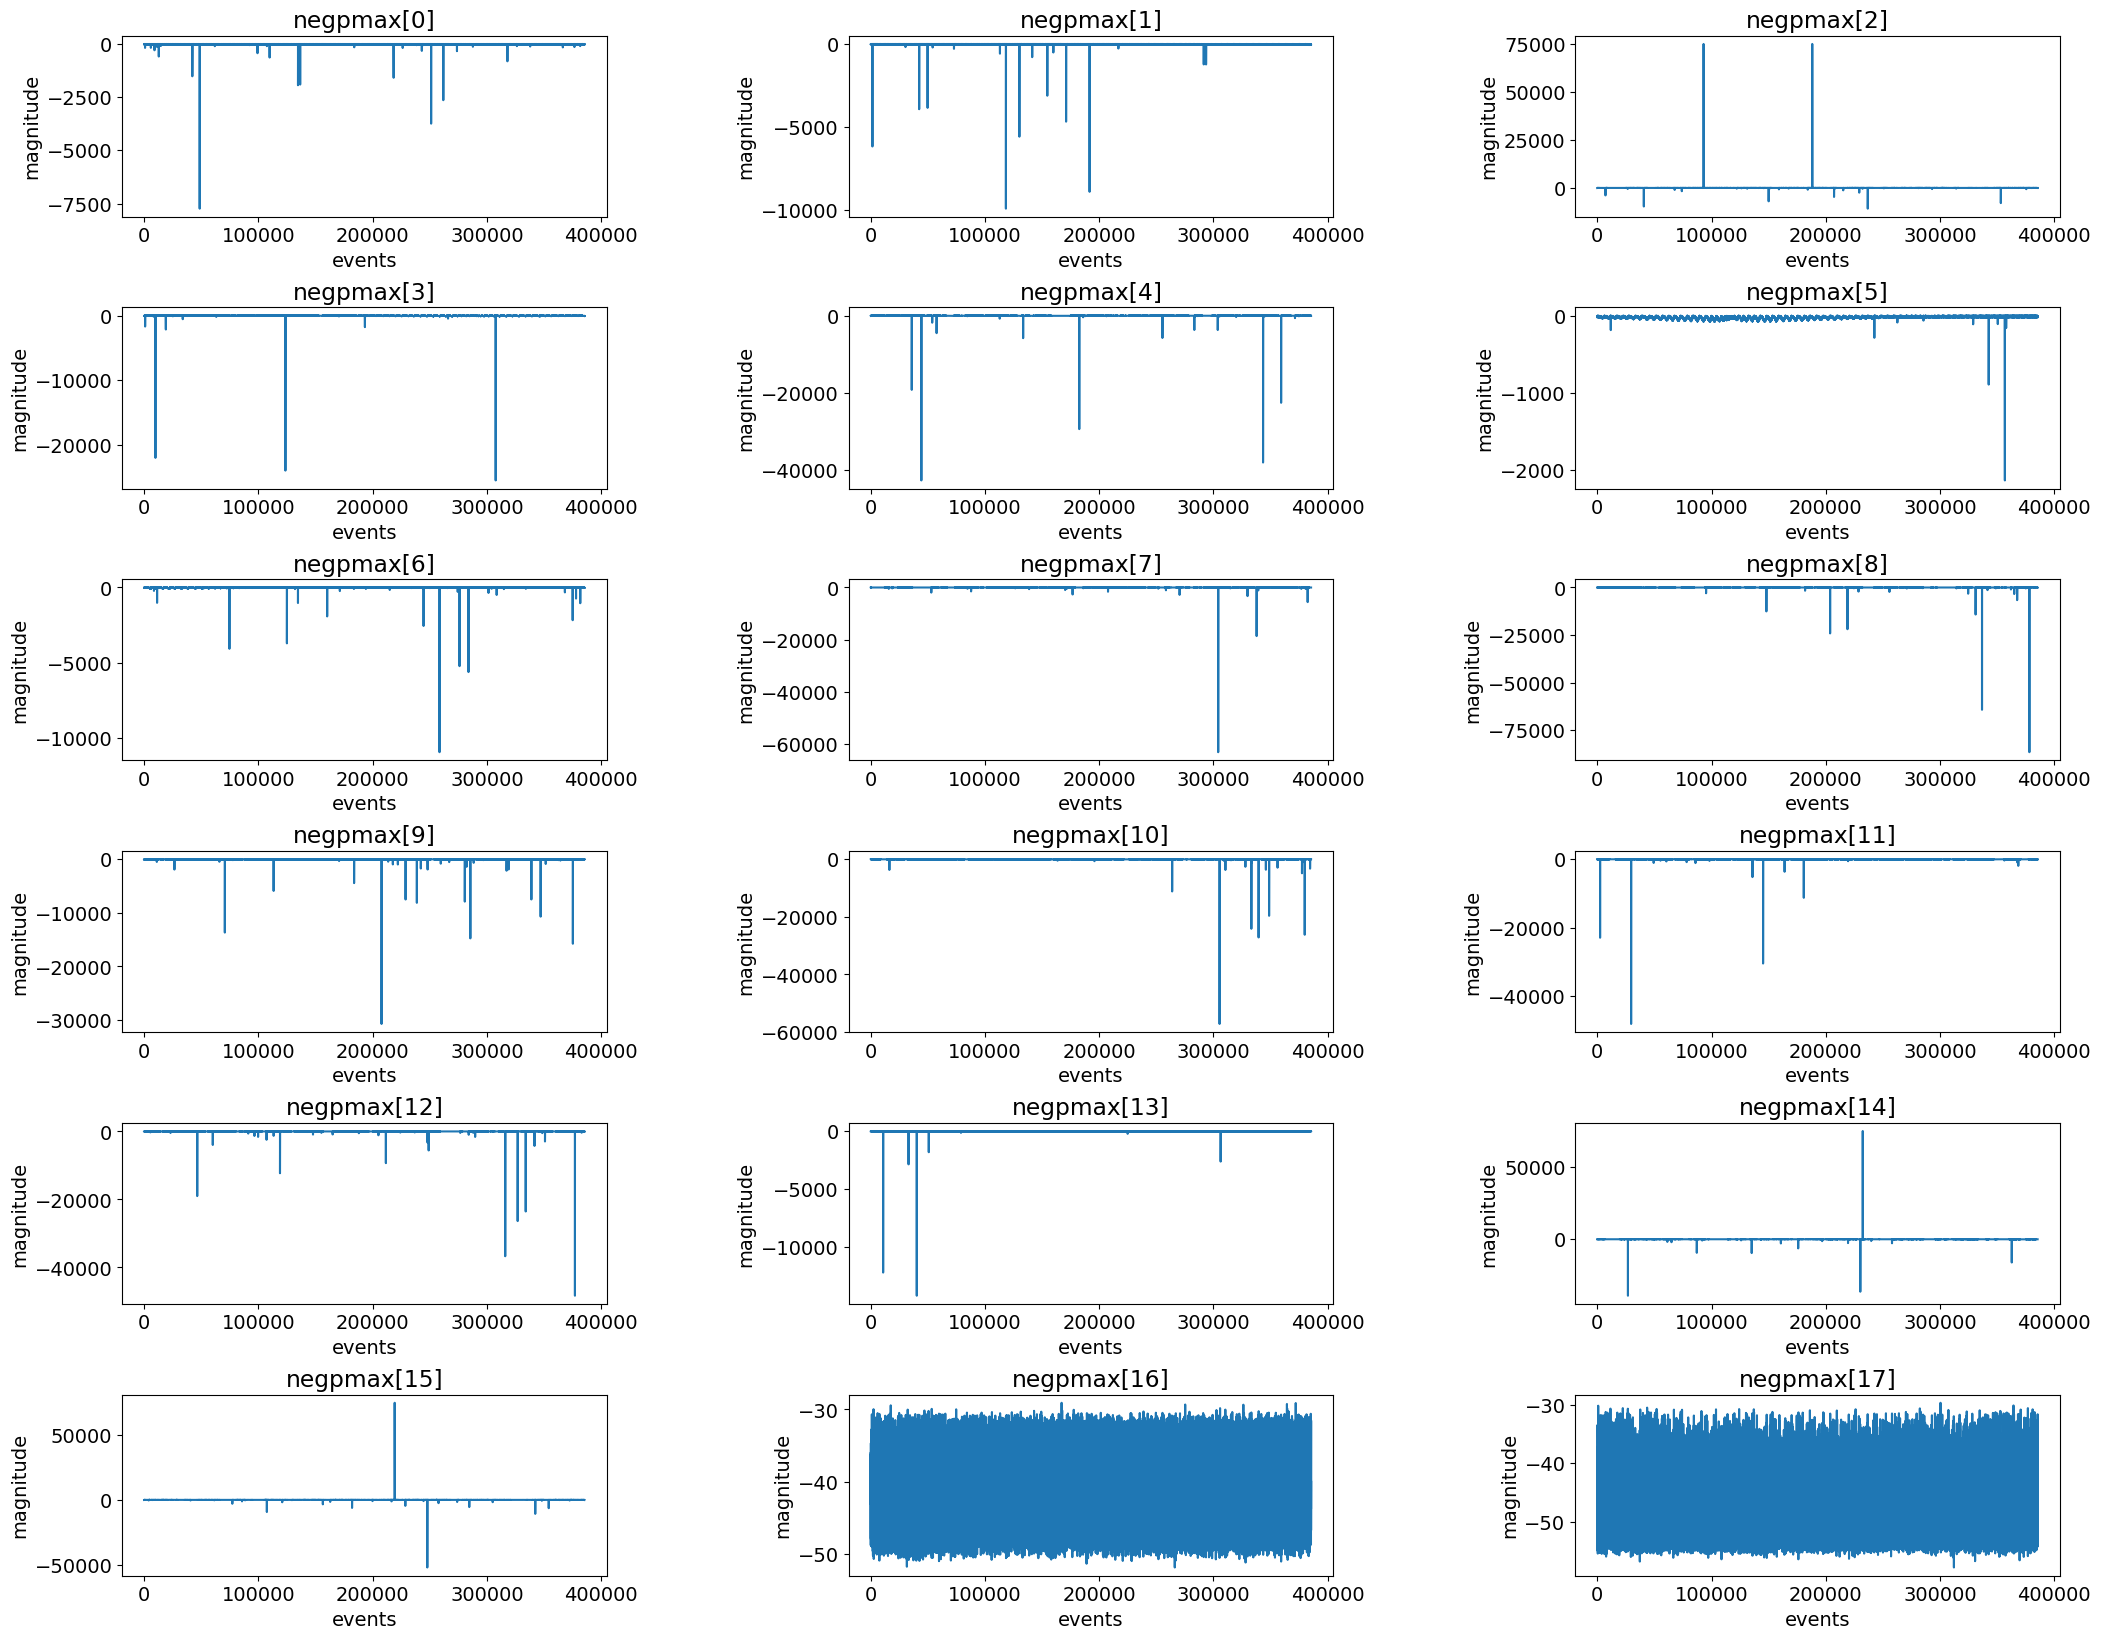

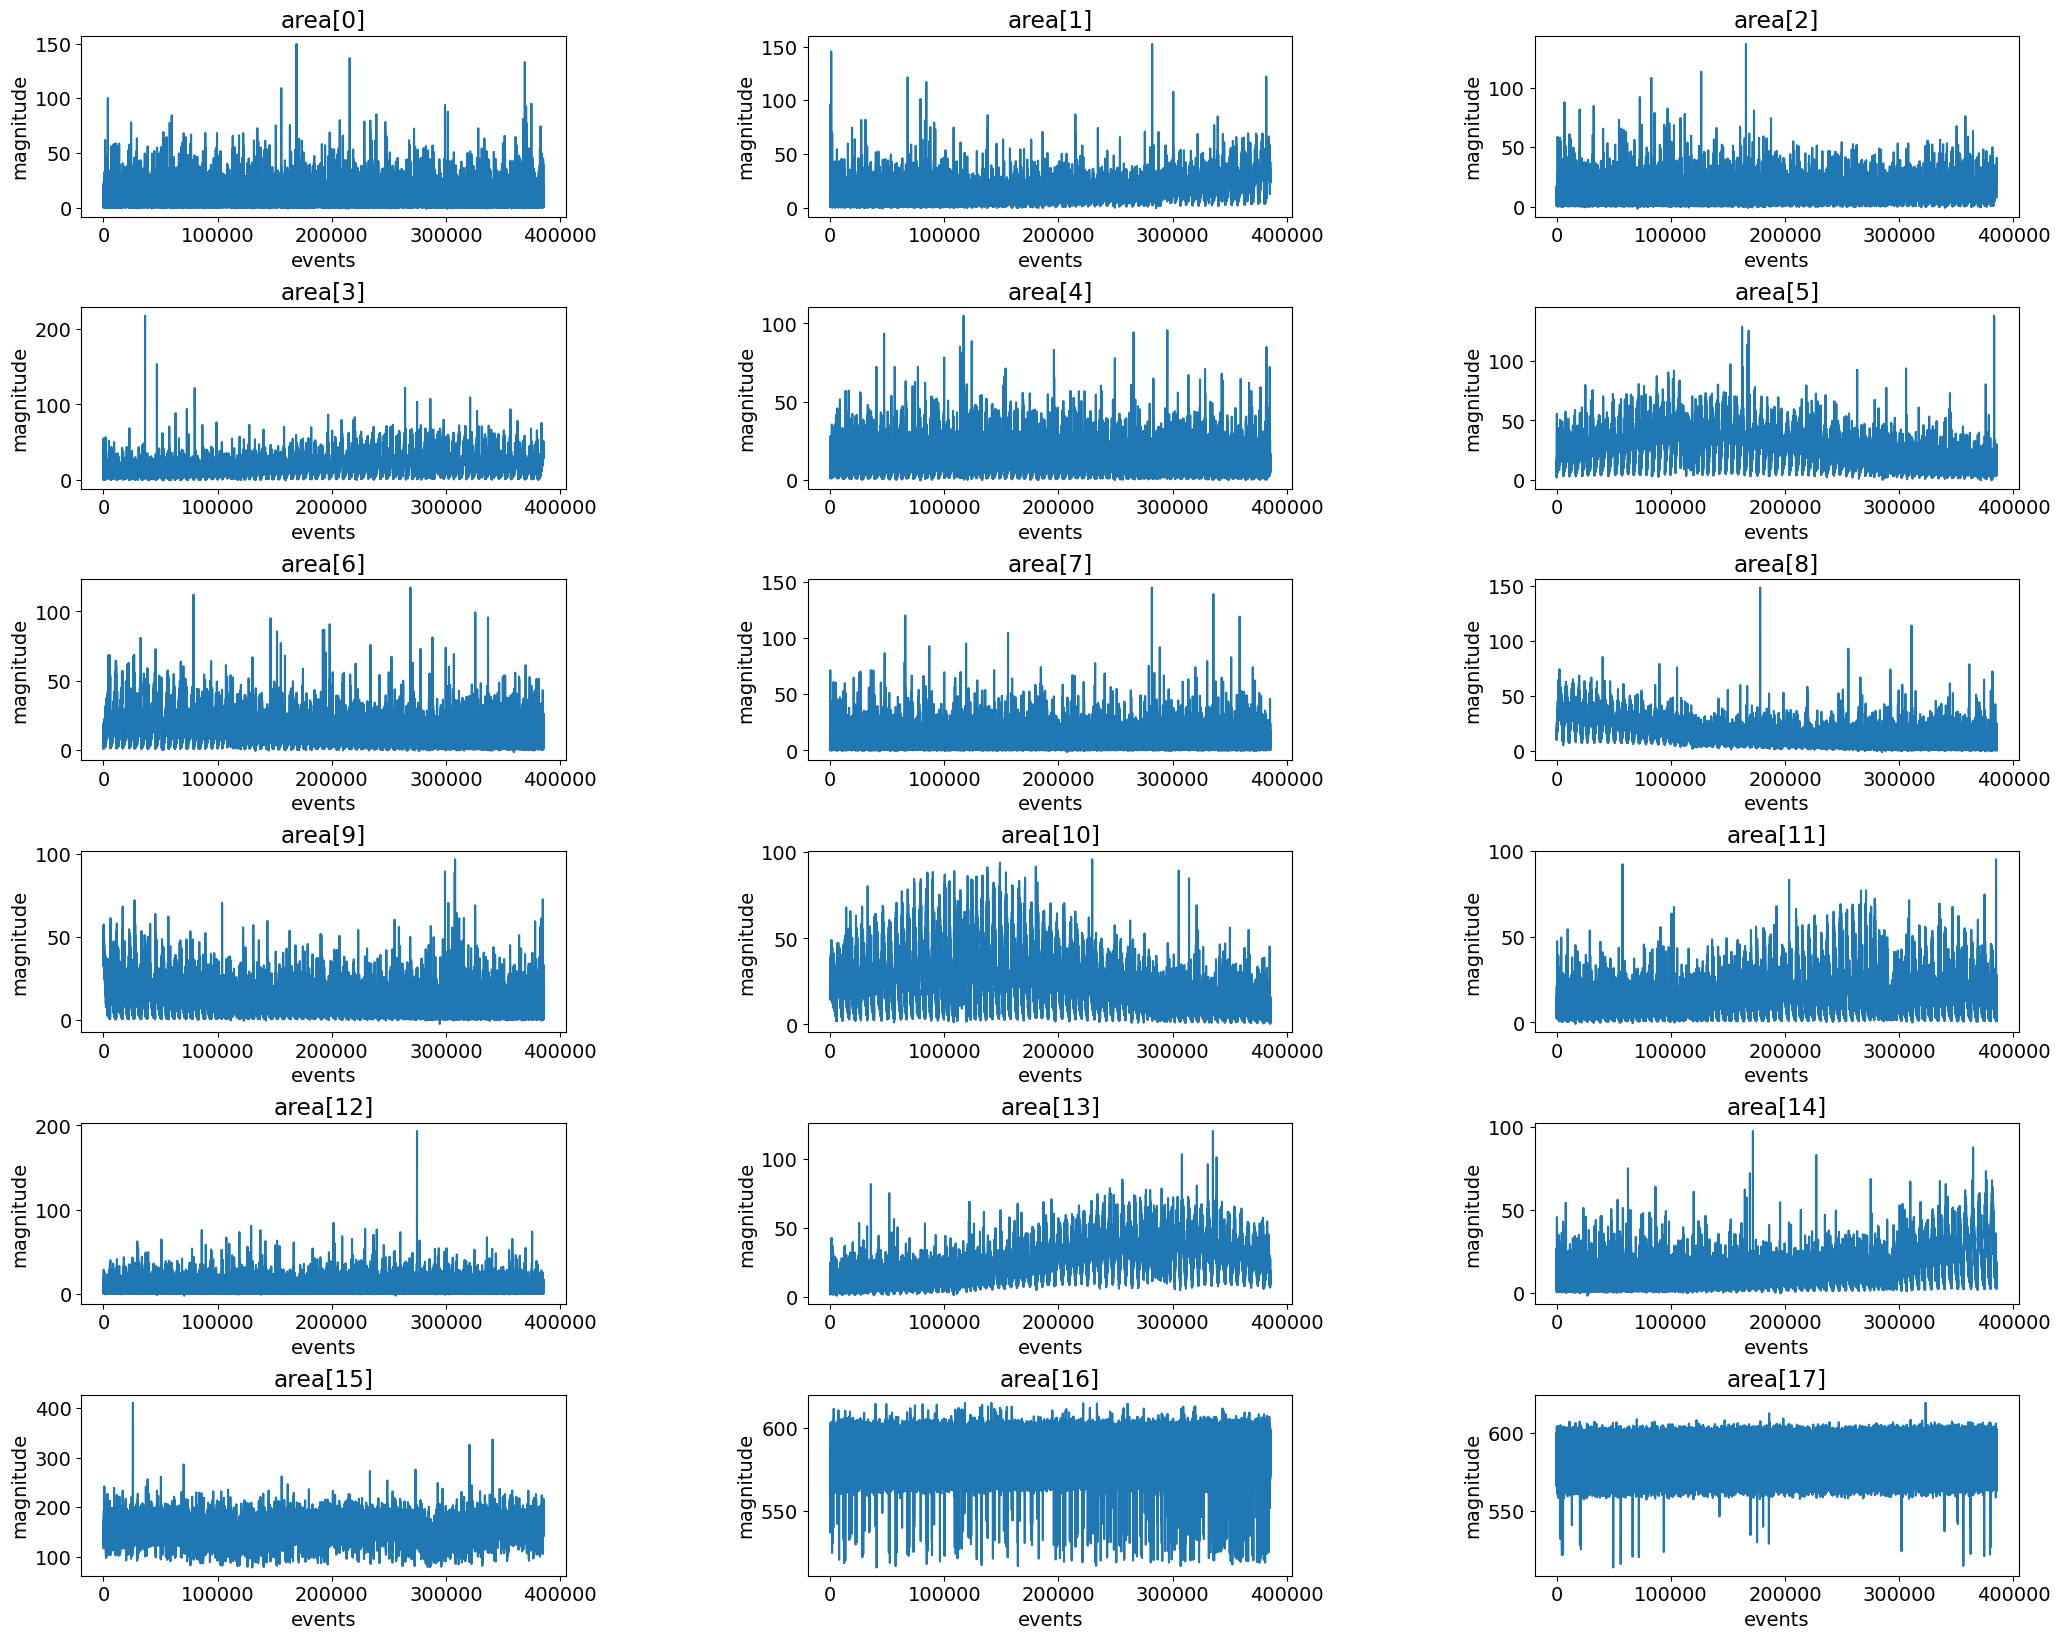

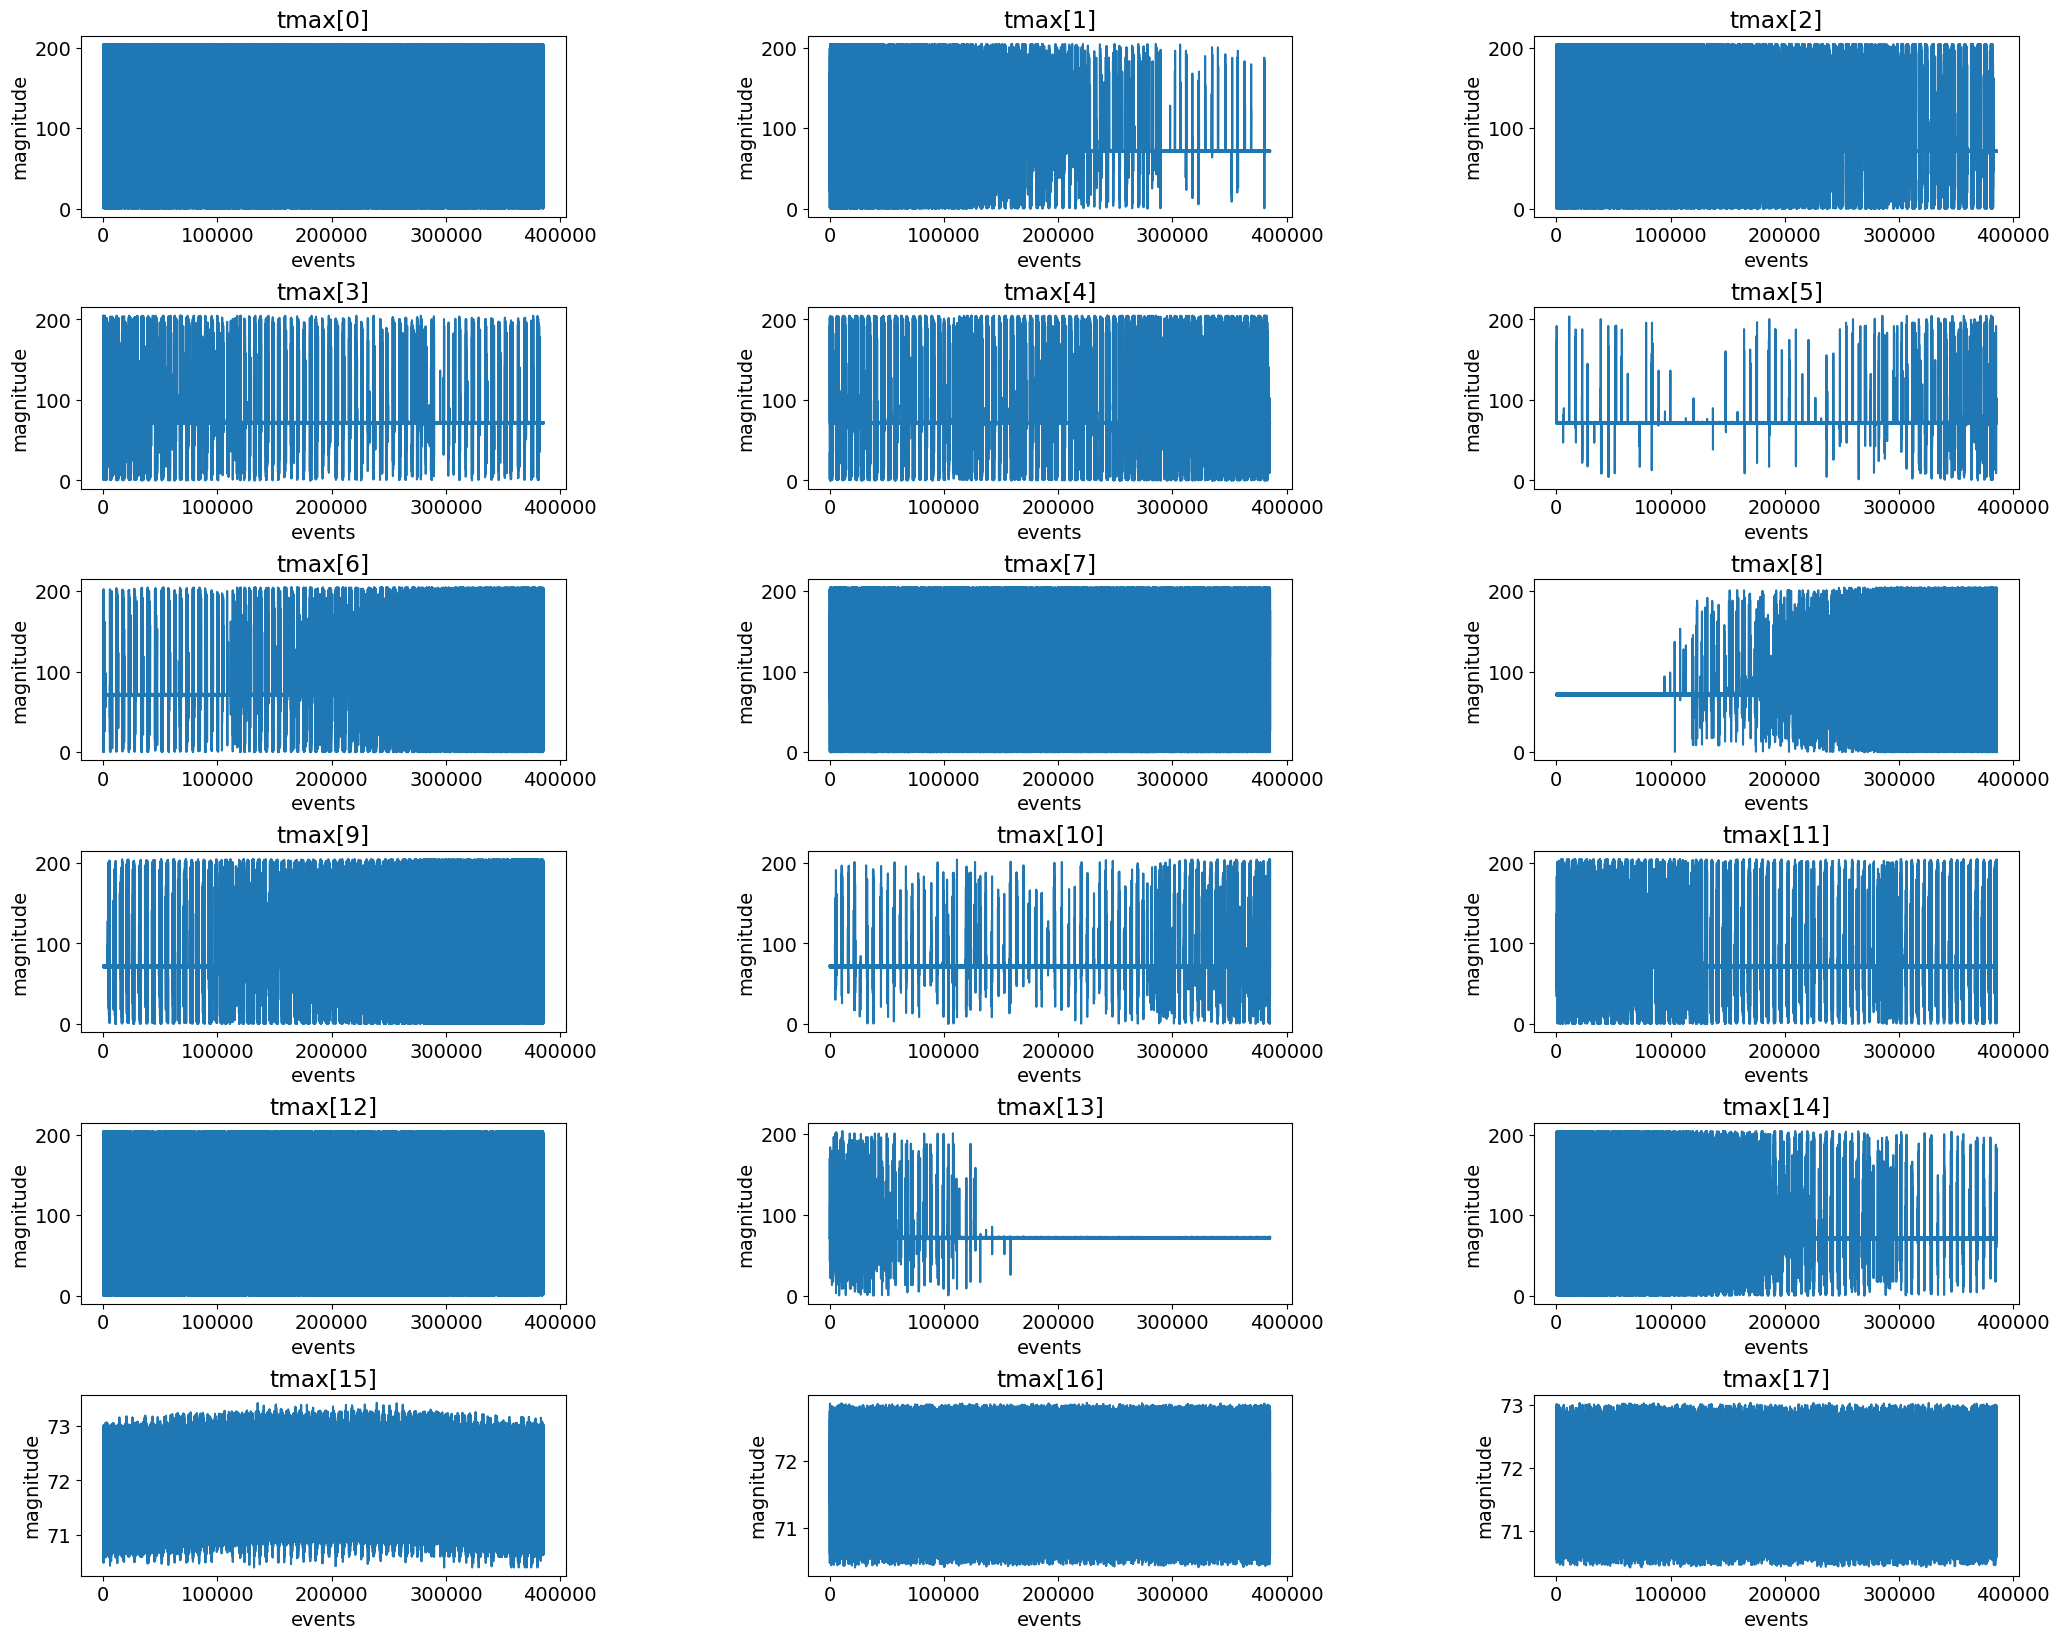

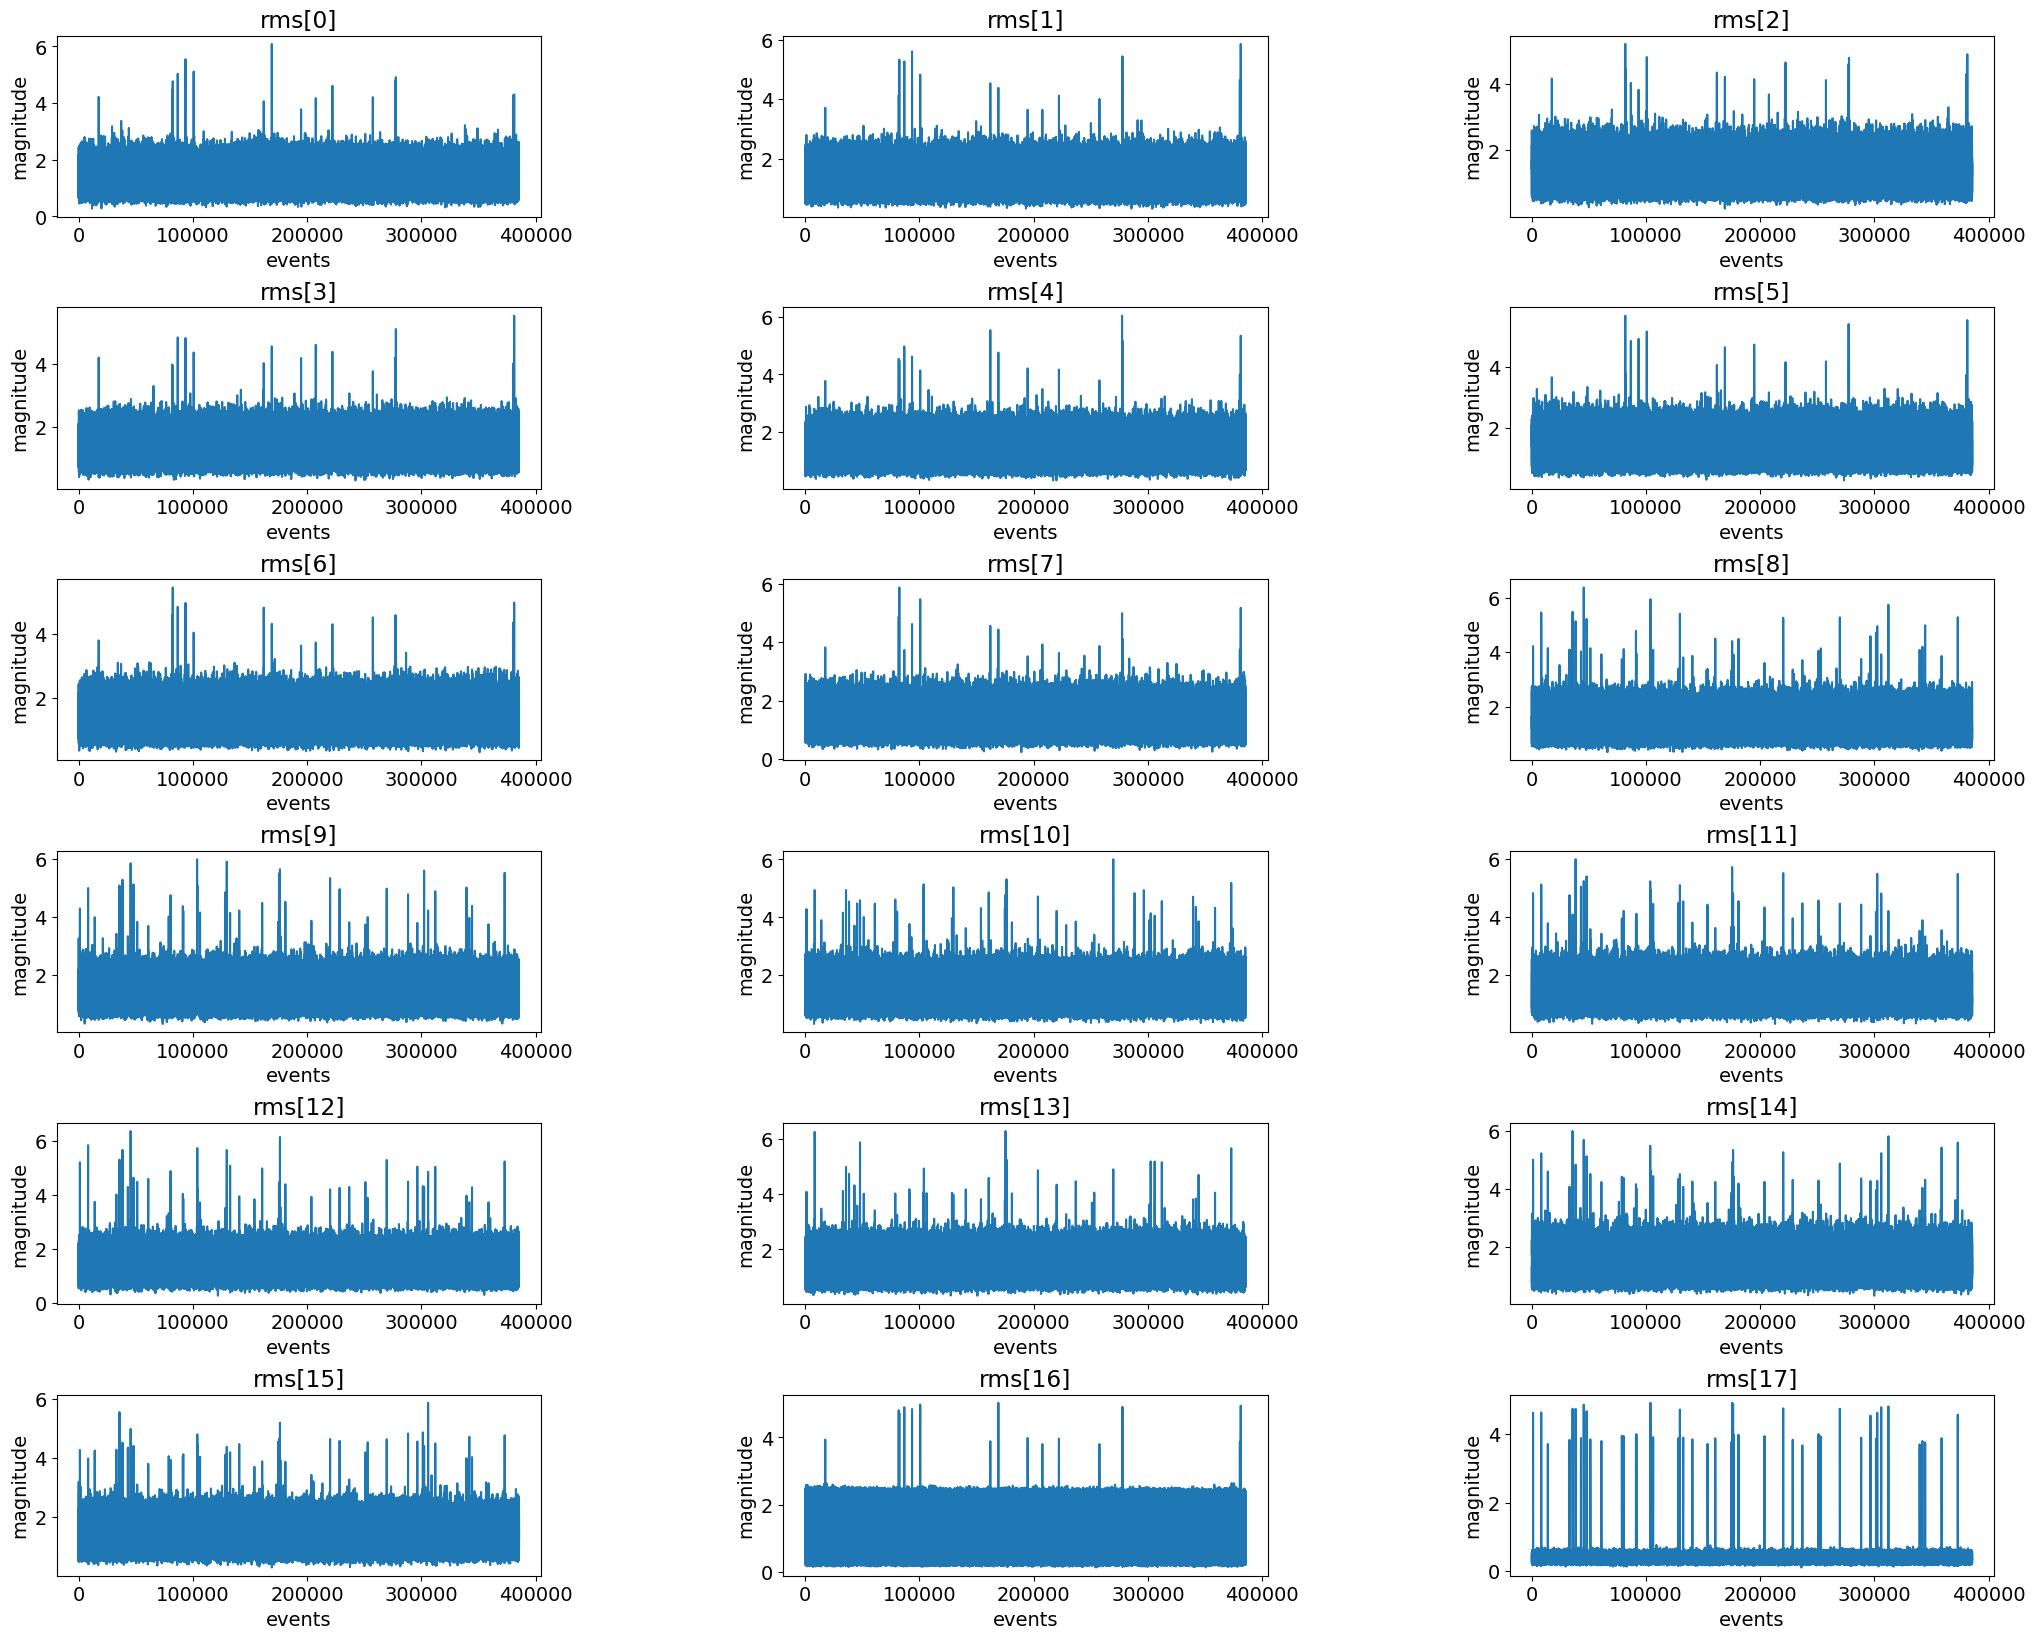

In [8]:
# Plot of all the features
mpl.rcParams["font.size"] = 14

for elem in ['pmax','negpmax','area','tmax','rms']:
    rows, cols = 6, 3
    fig, ax = plt.subplots(rows, cols, figsize=(25, 20))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    i=0
    for row in range(rows):
        for col in range(cols):
            ax[row, col].plot(df_dev[f'{elem}[{i}]'])
            ax[row,col].set_title(f'{elem}[{i}]')
            ax[row,col].set_xlabel('events')
            ax[row,col].set_ylabel('magnitude')
            i+=1
    plt.show()

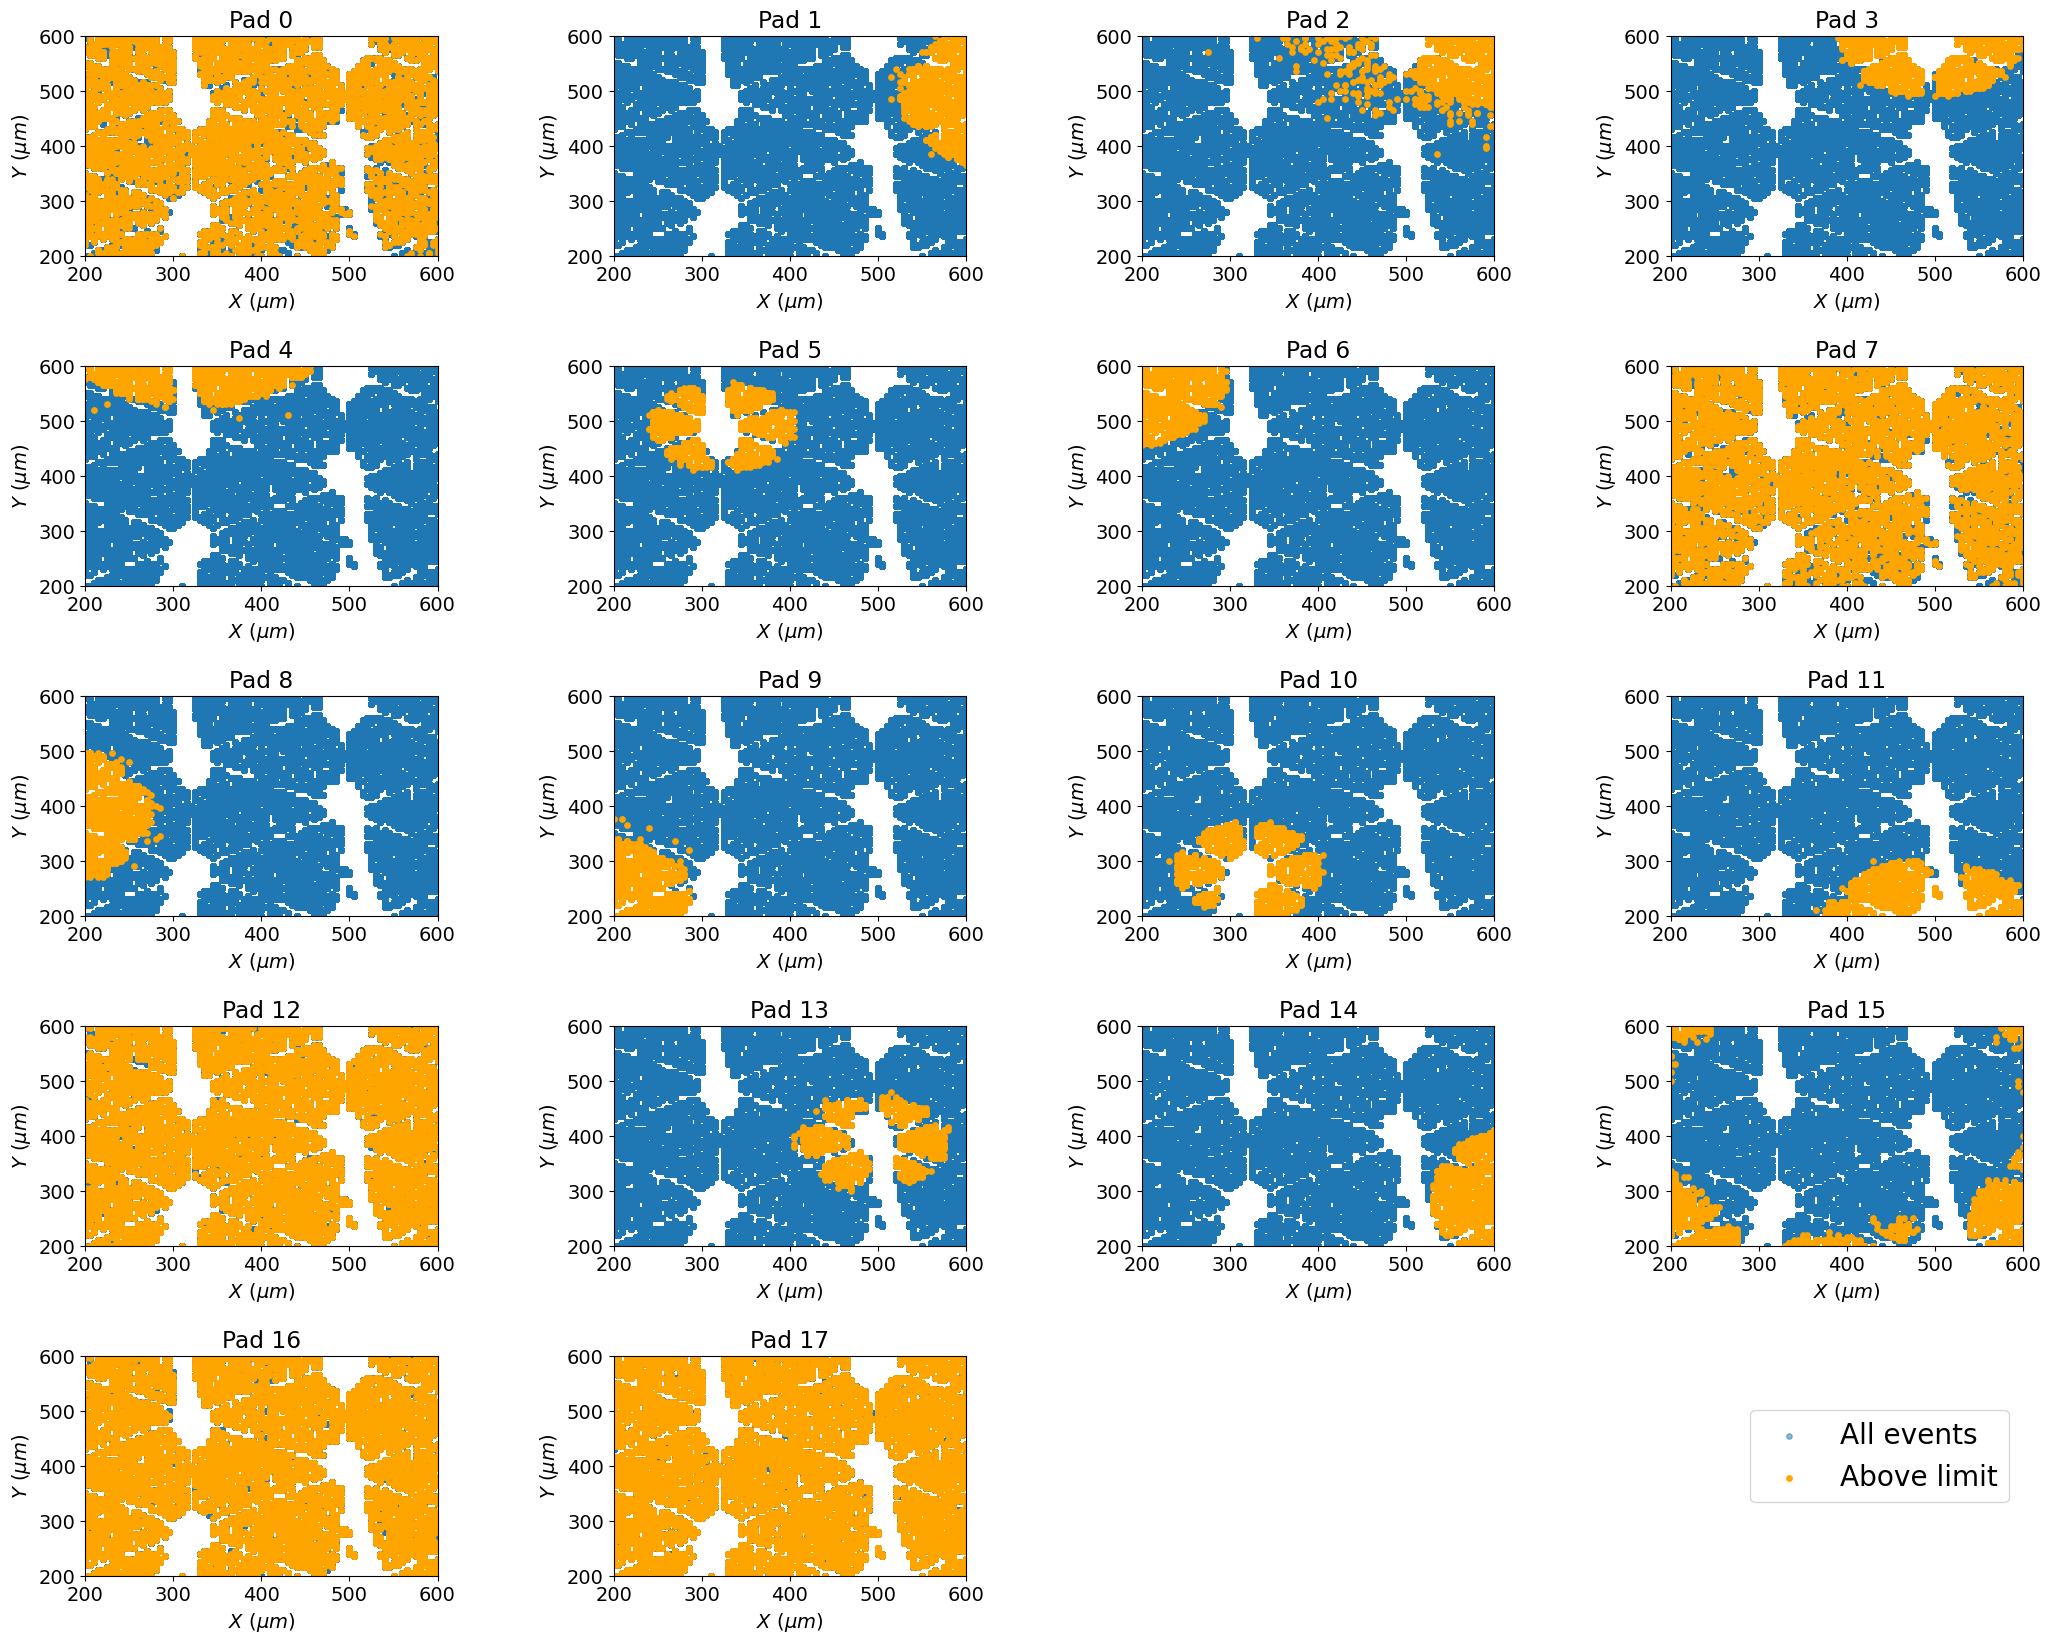

In [9]:
# Plot the pad position with respect to the pmax feature
mpl.rcParams["font.size"] = 14

elem = 'pmax'
rows, cols = 5, 4
fig, ax = plt.subplots(rows, cols, figsize=(25, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
i=0

for row in range(rows):
    for col in range(cols):
        if i < 18:
            limit = df_dev[f'{elem}[{i}]'].mean() + 2*df_dev[f'{elem}[{i}]'].std()
            mask = df_dev[f'{elem}[{i}]'] > limit
            ax[row, col].scatter(df_dev['x'],df_dev['y'], s=15, alpha=0.5)
            ax[row, col].scatter(df_dev[mask]['x'],df_dev[mask]['y'],c='orange', s=15)
            ax[row,col].set_title(f'Pad {i}')
            ax[row,col].set_xlabel('$X$ ($\\mu m$)')
            ax[row,col].set_ylabel('$Y$ ($\\mu m$)')
            ax[row, col].set_xlim(200, 600)
            ax[row, col].set_ylim(200, 600)
        i+=1
        
# Remove empty subplots
fig.delaxes(ax[4, 2])
fig.delaxes(ax[4, 3])

fig.legend(labels=['All events', 'Above limit'],fontsize='x-large', bbox_to_anchor=[0.9, 0.2])
plt.show()

### 4 - Remove noise features

Looking at the previous graph, we can see that the noise belongs to the supposed "pads": 0, 7, 12, 15, 16 and 17. Regarding "pad" 15, it was not easy to determine whether or not it was causing noise. But, looking at the last graph, we can see that the alleged "pad" 15 can detect high voltage spikes on areas of the sensor that are far apart. This suggests that it is indeed a source of noise.

In [10]:
# List of feature indices with noise
noise_features = [0,7,12,15,16,17]
# List of feature indices without noise
no_noise_features = [elem for elem in np.arange(18) if elem not in noise_features]

In [11]:
# Remove noise features
for i in noise_features:
   df_dev = df_dev.drop(columns=[f'pmax[{i}]',f'negpmax[{i}]',f'area[{i}]',f'tmax[{i}]',f'rms[{i}]'])

### 5 - Outlier detection

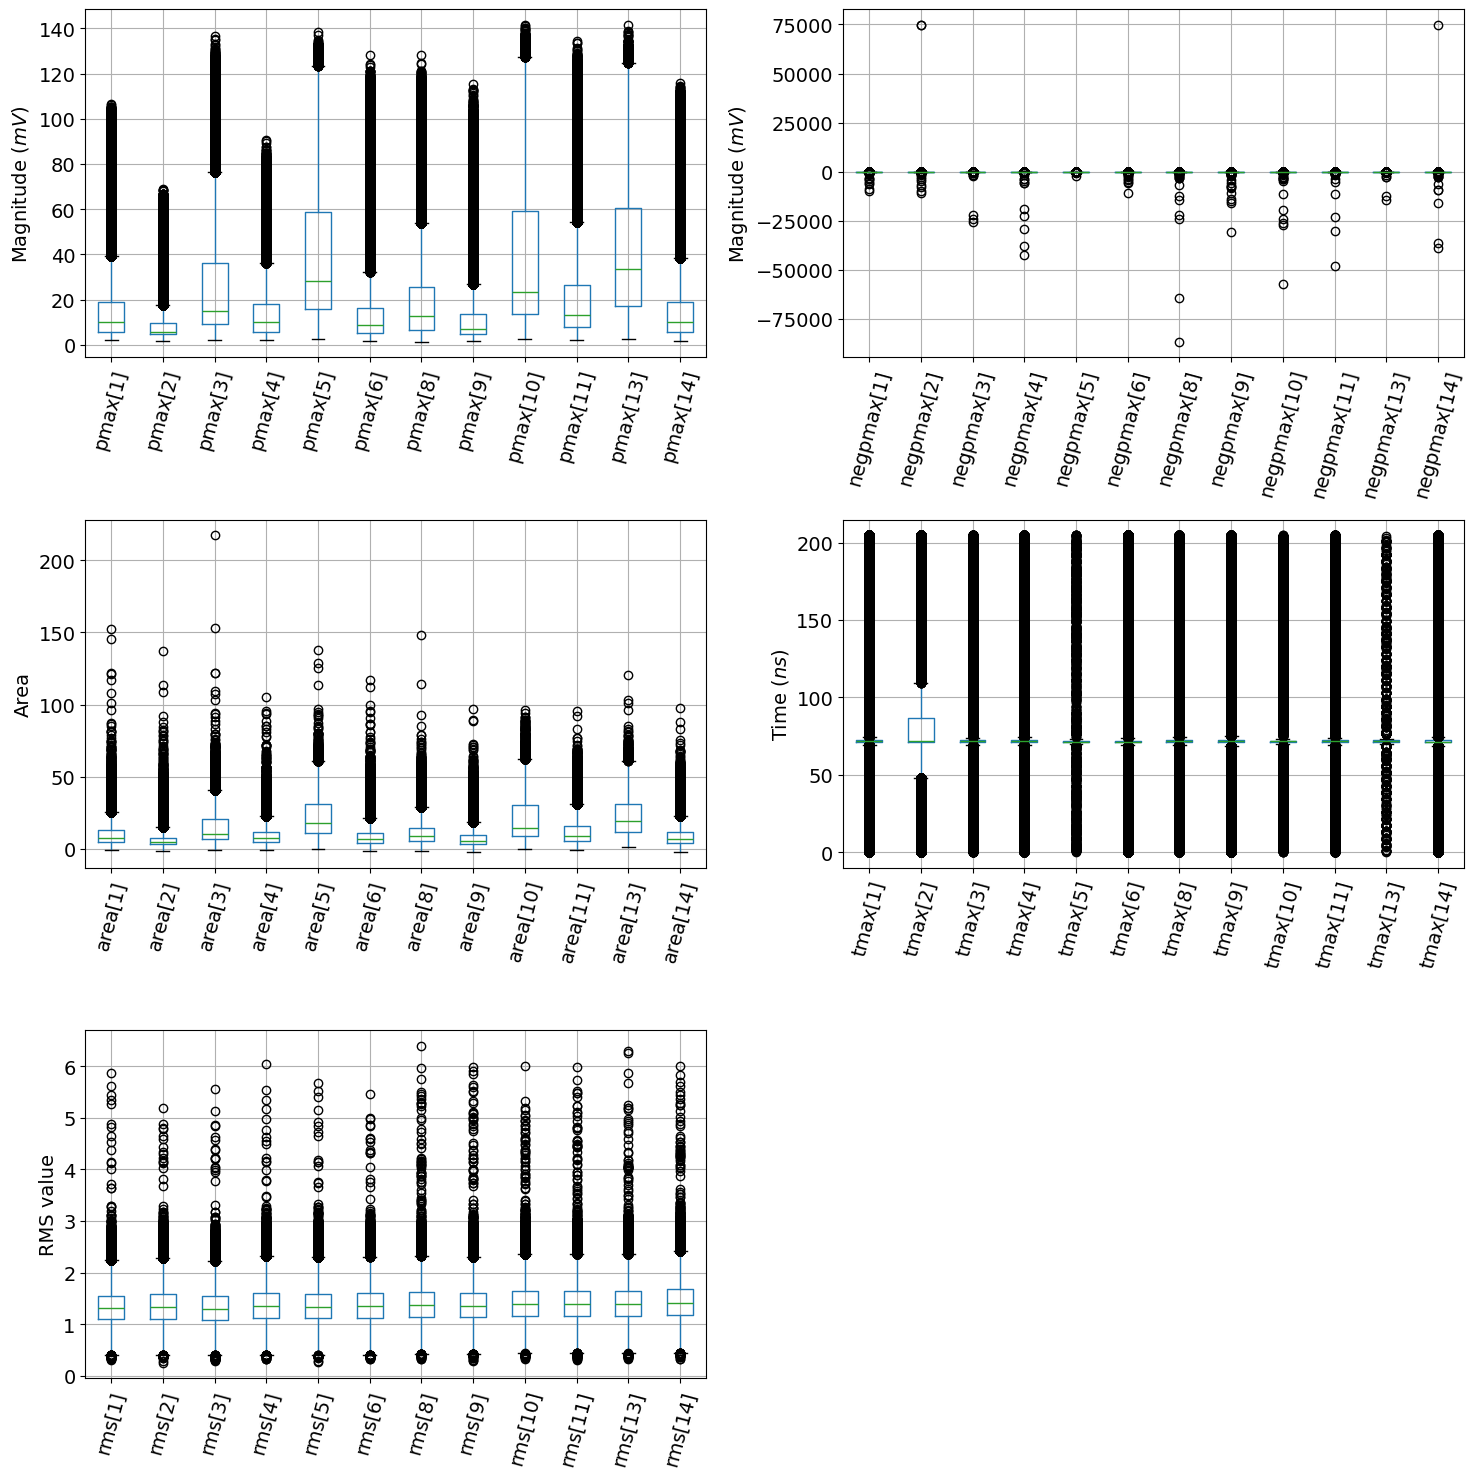

In [12]:
# Boxplots of every features

# Font size
mpl.rcParams["font.size"] = 14

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# First row
for idx, elem in enumerate(['pmax', 'negpmax']):
    df_dev[[f'{elem}[{i}]' for i in no_noise_features]].boxplot(ax=ax[0, idx])
    # Set labels
    ax[0, idx].set_xticklabels(ax[0, idx].get_xticklabels(), rotation=75)
    ax[0, idx].set_ylabel('Magnitude ($mV$)')

# Second row
for idx, elem in enumerate(['area', 'tmax']):
    df_dev[[f'{elem}[{i}]' for i in no_noise_features]].boxplot(ax=ax[1, idx])
    # Set labels
    ax[1, idx].set_xticklabels(ax[1, idx].get_xticklabels(), rotation=75)
    if elem == 'area' :
        ax[1, idx].set_ylabel('Area')
    else:
        ax[1, idx].set_ylabel('Time ($ns$)')

# Third row
for idx, elem in enumerate(['rms']):
    df_dev[[f'{elem}[{i}]' for i in no_noise_features]].boxplot(ax=ax[2, idx])
    # Set labels
    ax[2, idx].set_xticklabels(ax[2, idx].get_xticklabels(), rotation=75)
    ax[2, idx].set_ylabel('RMS value')

# Remove empty subplot in the third row
fig.delaxes(ax[2, -1])

plt.tight_layout()
plt.show()

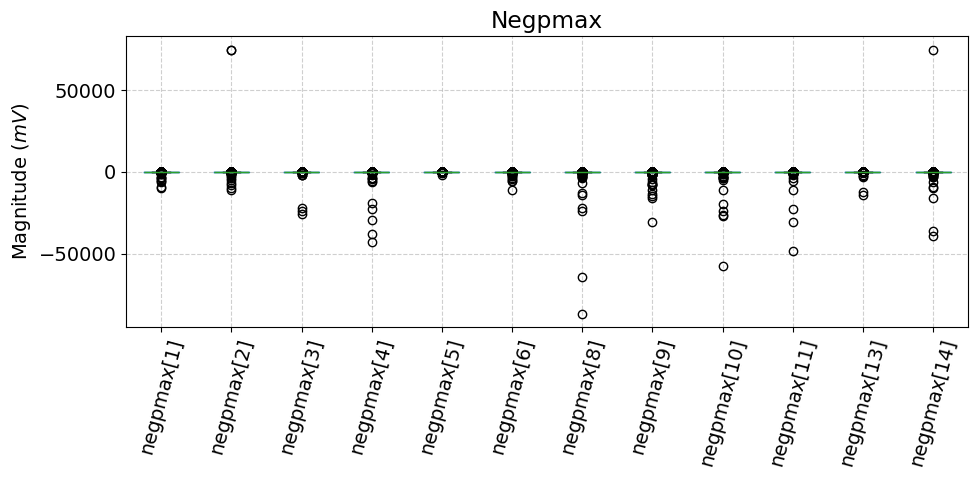

In [13]:
# Boxplot of negpmax feature

# Font size
mpl.rcParams["font.size"] = 14

fig, ax = plt.subplots(figsize=(10, 5))
df_dev[[f'negpmax[{i}]' for i in no_noise_features]].boxplot(ax=ax)

# Set title and labels
ax.set_title('Negpmax')
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
ax.set_ylabel('Magnitude ($mV$)')

plt.grid(linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [14]:
# Remove positive negpmax values
print('Number of lines before removing positive values from negpmax:', df_dev.shape[0])

for i in no_noise_features:
    df_dev = df_dev.drop( df_dev[df_dev[f'negpmax[{i}]'] > 0].index )
df_dev.reset_index(drop=True,inplace= True)
print('Number of lines after removing positive values from negpmax:', df_dev.shape[0])

Number of lines before removing positive values from negpmax: 385500
Number of lines after removing positive values from negpmax: 385497


We now present two possible approaches for removing outliers

##### 5.1 - ZSCORE OVER SEPARATE PADS

In [15]:
# Compute the z-score, for each pad, and create a dedicated column to represent it
df_no_outliers = df_dev.copy()

for i in no_noise_features:
    list_zscore = []
    for elem in ['pmax','negpmax','area','tmax','rms']:
        # Pick values
        rows = df_no_outliers[[f'{elem}[{i}]']].values
        # Compute the z-score and append it in list_values
        list_zscore.append((rows - rows.mean()) / rows.std())
    # Add new column
    df_no_outliers[f'zscore[{i}]'] = np.array(list_zscore).mean(axis=0)

In [16]:
# Display the dataframe
zscore_col = [col for col in df_no_outliers.columns if col.startswith('zscore')]
df_no_outliers[zscore_col].head()

,zscore[1],zscore[2],zscore[3],zscore[4],zscore[5],zscore[6],zscore[8],zscore[9],zscore[10],zscore[11],zscore[13],zscore[14]
0,-0.560577,-0.289096,-1.065582,-0.526683,-0.384784,-0.775764,-0.041315,2.009755,0.003191,-0.506551,-0.556214,0.222784
1,-0.109127,-0.154890,1.294302,0.163095,-0.210923,-0.044493,0.006899,2.312282,-0.118328,0.150970,3.192347,0.038250
2,-0.272981,-0.465319,1.526277,-0.576080,-0.161005,-0.109902,0.178894,2.152503,0.308163,0.039397,-0.342384,-0.809644
3,0.469399,-0.779123,0.095453,0.805397,-0.551504,0.035052,-0.277662,2.422815,-0.094139,-0.199279,-0.061151,0.158900
4,-0.116709,-0.315924,-0.288501,-0.851696,0.033522,0.000135,0.149360,2.397066,0.133801,-0.251473,-0.298195,0.194493


In [17]:
def get_index_zscore(df, threshold):
    return df[(df > threshold) | (df < -threshold)].index


threshold = 0.25
index_dict = {f'index_s{i}zscore': get_index_zscore(df_no_outliers[f'zscore[{i}]'], threshold) for i in no_noise_features}

index_list_zscore = np.concatenate([index for _, index in index_dict.items()])

# Counter
counter = Counter(index_list_zscore)

index_to_remove = [key for key, count in counter.items() if count == 12] # 12 = number of pads

# df_no_outliers length
last_dim = df_no_outliers.shape[0]

# drop z-score's columns
df_no_outliers = df_no_outliers.drop(index_to_remove).drop(columns=zscore_col)

# Print how many rows have been removed
print(f'Non-outlier observations: {df_no_outliers.shape[0]}')
print(f'Identified outliers: {last_dim - df_no_outliers.shape[0]}')
print()

Non-outlier observations: 385282
Identified outliers: 215



##### 5.2 - MAHALANOBIS DISTANCE 

In [18]:
df_no_outliers = df_dev.copy()

# Calculate mean and inverse covariance matrix

mean = df_no_outliers.drop(columns=['x','y']).mean()

covariance_matrix = df_no_outliers.drop(columns=['x','y']).cov()

cov_inv = pd.DataFrame(np.linalg.inv(covariance_matrix.values), 
                       columns = df_no_outliers.drop(columns=['x','y']).columns, 
                       index = df_no_outliers.drop(columns=['x','y']).columns)

# Calculate Mahalanobis distance for each data point
df_no_outliers['mahalanobis_distance'] = df_no_outliers.drop(columns=['x','y']).apply(lambda x: mahalanobis(x, mean, cov_inv), axis=1)

In [19]:
# Set the threshold
threshold = df_no_outliers['mahalanobis_distance'].mean() +  7 * df_no_outliers['mahalanobis_distance'].std()

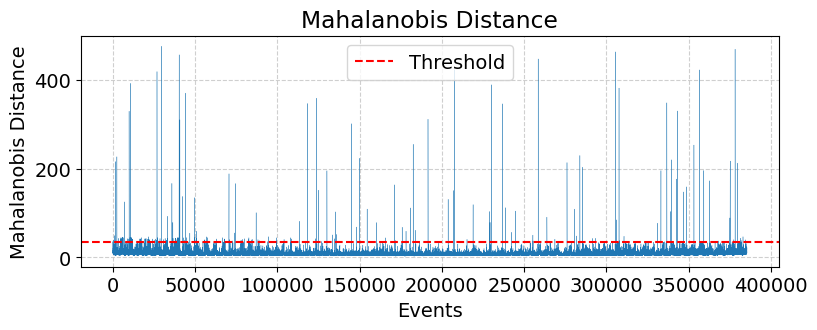

In [20]:
# Font size
mpl.rcParams["font.size"] = 14

# Plot the mahalanobis_distance over the events
plt.figure(figsize=(9,3))
plt.plot(df_no_outliers['mahalanobis_distance'], linewidth=0.25)
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

# Set title and labels
plt.title('Mahalanobis Distance')
plt.xlabel('Events')
plt.ylabel('Mahalanobis Distance')

plt.legend()
plt.grid(linestyle='--', alpha=0.6)
plt.show()

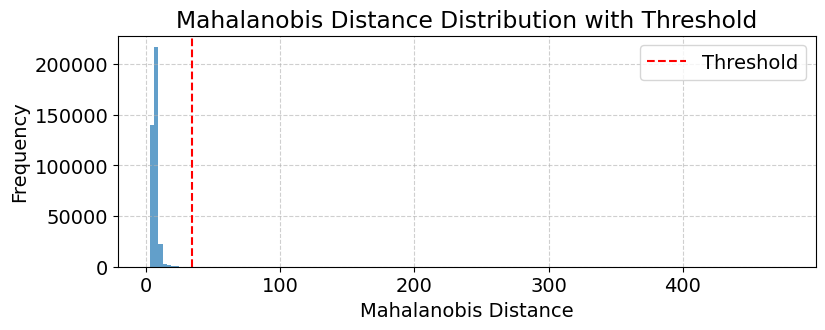

In [21]:
# Font size
mpl.rcParams["font.size"] = 14

# Plot the Mahalanobis Distance distribution
plt.figure(figsize=(9,3))
plt.hist(df_no_outliers['mahalanobis_distance'], bins=150, alpha=0.7)
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')

# Set title and labels
plt.title('Mahalanobis Distance Distribution with Threshold')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')

plt.legend()
plt.grid(linestyle='--', alpha=0.6)
plt.show()

In [22]:
# Number of outliers
n_outlier = df_no_outliers[df_no_outliers['mahalanobis_distance'] >= threshold].shape[0]

# df_no_outliers length
last_dim = df_no_outliers.shape[0]

# Remove outliers
df_no_outliers = df_no_outliers[df_no_outliers['mahalanobis_distance'] < threshold]
df_no_outliers.reset_index(drop=True,inplace=True)

# Print how many rows have been removed
print(f'Non-outlier observations: {df_no_outliers.shape[0]}')
print(f'Identified outliers: {last_dim - df_no_outliers.shape[0]}')
print()

Non-outlier observations: 385246
Identified outliers: 251



In [23]:
# Drop columns related to mahalanobis distance
df_no_outliers = df_no_outliers.drop(columns='mahalanobis_distance')

### 6 - Features selection

In [24]:
# Train-test split for feature selection
X = df_no_outliers.drop(columns=['x', 'y']).values
y = df_no_outliers[['x', 'y']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, shuffle=True, random_state=random_state)

In [25]:
# Random Forest
reg = RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1)

# Fit the model
reg.fit(X_train , y_train)

print('Adjusted R^2 score:',r2_score(y_test, reg.predict(X_test)))

Adjusted R^2 score: 0.9989083135978132


In [26]:
# Feature importances
feature_names = df_no_outliers.drop(columns=['x', 'y']).columns

feature_importances_list = sorted(zip(feature_names, reg.feature_importances_), key = lambda x: x[1], reverse = True)

feature_importances_list

[('pmax[8]', 0.3589734244717652),
 ('pmax[11]', 0.24192409242407195),
 ('pmax[10]', 0.16344987580972495),
 ('pmax[5]', 0.08193755019740152),
 ('pmax[13]', 0.03616186750346716),
 ('negpmax[13]', 0.0256894714843019),
 ('pmax[9]', 0.020938274259979437),
 ('negpmax[11]', 0.012814284101782265),
 ('negpmax[3]', 0.011504419521569081),
 ('negpmax[10]', 0.008051582716188098),
 ('negpmax[8]', 0.00536061313831303),
 ('negpmax[5]', 0.004862272248052369),
 ('pmax[3]', 0.004473972658698564),
 ('negpmax[1]', 0.004274077395011743),
 ('pmax[4]', 0.004026228074291762),
 ('negpmax[6]', 0.0028657109566274726),
 ('pmax[2]', 0.0021061858714567787),
 ('negpmax[14]', 0.00206080684927294),
 ('negpmax[4]', 0.0019440282804675559),
 ('pmax[1]', 0.0016935502379987531),
 ('pmax[6]', 0.0013198365745605942),
 ('negpmax[9]', 0.0012442518990665903),
 ('pmax[14]', 0.000934214579692177),
 ('area[3]', 0.0002210367653662123),
 ('negpmax[2]', 0.0001839054553011868),
 ('area[5]', 0.0001644818580607175),
 ('area[13]', 0.00010

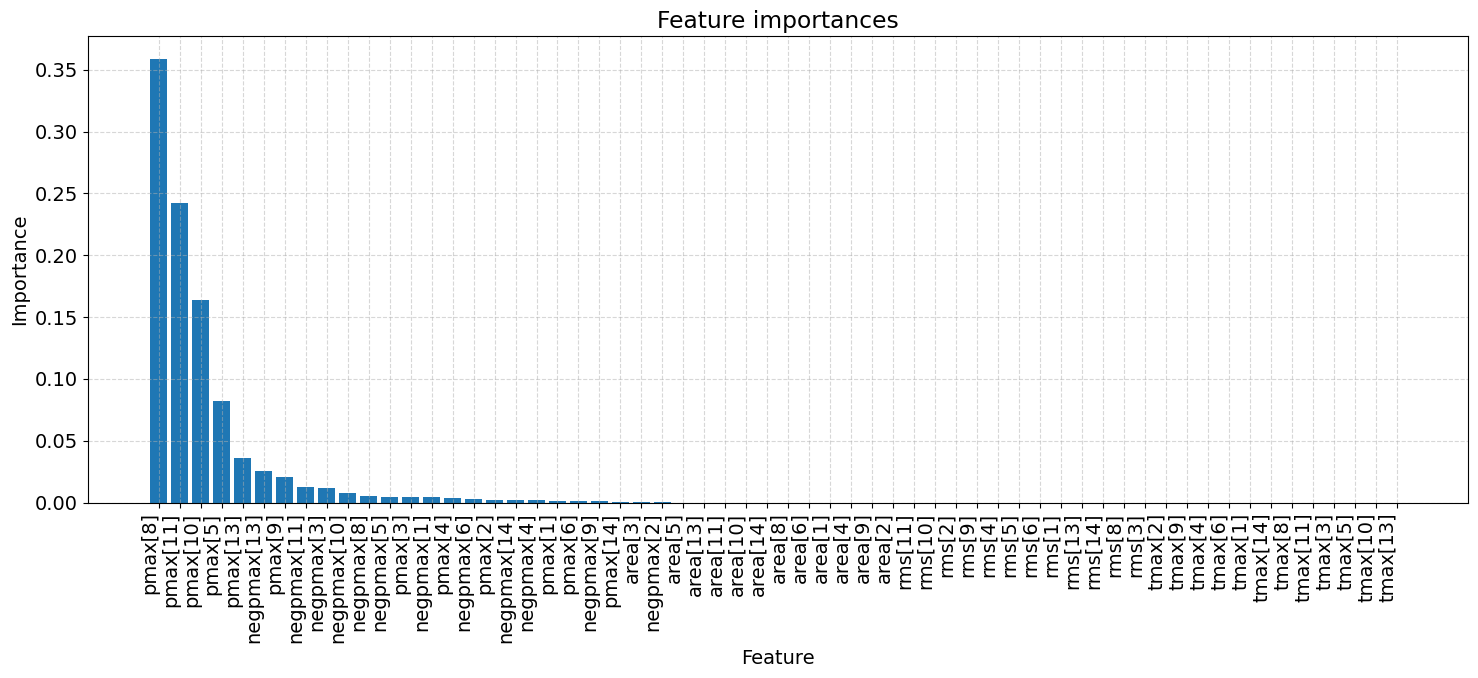

In [27]:
# Plot the feature importances

# Extract feature names and importances from the list
feature_names, importances = zip(*feature_importances_list)

# Font size
mpl.rcParams["font.size"] = 14

# Vertical bar chart
plt.figure(figsize=(15, 7))
plt.bar(feature_names, importances)

# Set title and labels
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature importances')
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.grid(linestyle='--', alpha=0.5)
plt.show()

As indicated by the importance given to the different features, it is evident that the worst features are represented by tmax and rms. Therefore, we will proceed with the removal of these features in order to reduce the size of the dataset.

In [28]:
# Removing tmax and rms
for i in no_noise_features:
    df_no_outliers = df_no_outliers.drop(columns=[f'tmax[{i}]',f'rms[{i}]'])

In [29]:
# Rename the dataset
df_clean = df_no_outliers

### 7 - Model implementation

In [30]:
# Train-test split
X = df_clean.drop(columns=['x', 'y']).values
y = df_clean[['x', 'y']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, shuffle=True, random_state=random_state)

##### 7.1 - Random Forest Regressor

To identify the best hyperparameters for the model, we performed a grid search, dividing it into two parts to efficiently distribute the required computational cost.

In [31]:
# First grid search in order to know the best number of n_estimators

param_grid = {
    'n_estimators': [i for i in range(100,1000,100)],
    "random_state": [random_state],
    "n_jobs": [-1]
}

# Grid search
gs = GridSearchCV(RandomForestRegressor(), param_grid, scoring='r2', n_jobs=-1, cv=5)

# Fit
gs.fit(X_train, y_train)

# Print the best parameters
print(f'GridSearchCV best params: {gs.best_params_}')

From the first one we realized that the more the number of estimators the better the model performs. at this point we proceeded with the second one with the purpose of comparing other hyperparameters

In [32]:
# Second grid search in order to compare other hyperparameters
param_grid = {
    'n_estimators': [100],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, 30, 40 ,50, None],
    'min_samples_split': [2, 4 ,5 ,8 ,10],
    'min_samples_leaf': [2, 4, 6, 8, 10],
    'bootstrap': [False],
    "random_state": [random_state],
    "n_jobs": [-1]
}

# Grid search
gs = GridSearchCV(RandomForestRegressor(), param_grid, scoring='r2', n_jobs=-1, cv=5)

# Fit
gs.fit(X_train, y_train)

# Print the best parameters
print(f'GridSearchCV best params: {gs.best_params_}')

So our best configuration for the Random Forest Regressor consists of the following hyperparameters:
- 'n_estimators':1000
- 'criterion':'squared_error'
- 'bootstrap': False
- 'max_depth': 40
- 'max_features': 'sqrt'
- 'min_samples_leaf': 2
- 'min_samples_split': 2
- 'n_jobs': -1
- 'random_state': 332078

In [33]:
# Make the best model
reg = RandomForestRegressor(n_estimators= 300,
                            criterion='squared_error',
                            bootstrap= False,
                            max_depth= 40,
                            max_features= 'sqrt',
                            min_samples_leaf= 2,
                            min_samples_split= 2,
                            n_jobs= -1,
                            random_state= random_state)

# Fit
reg.fit(X_train , y_train)

# Predict
reg_y_pred = reg.predict(X_test)

##### 7.2 - K-Neighbors Regressor

To identify the best hyperparameters for the model, we performed a grid search.

In [34]:
# chose the best weights and algorithm
param_grid = {'n_neighbors': [i for i in range(5,50,5)],
              'weights': ['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree', 'kd_tree'],
              "n_jobs": [-1]
             }


# Grid search
gs = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit
gs.fit(X_train, y_train)

# Print the best parameters
print(f'GridSearchCV best params: {gs.best_params_}')

So our best configuration for the K-Nearest Neighbors Regressor consists of the following hyperparameters:
- 'algorithm': 'auto'
- 'n_neighbors': 10
- 'weights': 'uniform'
- 'n_jobs': -1

In [35]:
# Make the best model
knn = KNeighborsRegressor(algorithm= 'auto',
                          n_neighbors= 10,
                          weights= 'uniform',
                          n_jobs= -1)

# Fit
knn.fit(X_train , y_train)

# Predict
knn_y_pred = knn.predict(X_test)

### 8 - Local evaluation

In [36]:
# Euclidean distance function for evaluation

def avg_euclidean_evaluation(y_true, y_pred):
    # distance
    distances = np.sqrt(np.sum((y_true - y_pred)**2, axis=1))
    # distance mean
    result = np.mean(distances)
    return result

##### 8.1 - Random Forest Regressor evaluation 

In [37]:
# R2 score
r2 = r2_score(y_test, reg_y_pred)
print(f'R2 Score: {r2:.4f}')

# MAE score
mae = mean_absolute_error(y_test, reg_y_pred)
print(f'Mean Absolute Error: {mae:.4f}')

# MSE score
mse = mean_squared_error(y_test, reg_y_pred)
print(f'Mean Squared Error: {mse:.4f}')

# Average euclidean distance score
distance = avg_euclidean_evaluation(y_test, reg_y_pred)
print(f'Average euclidean distance: {distance:.4f}')

R2 Score: 0.9991
Mean Absolute Error: 2.5985
Mean Squared Error: 11.8042
Average euclidean distance: 4.0756


##### 8.2 - K-Neighbors Regressor

In [38]:
# R2 score
r2 = r2_score(y_test, knn_y_pred)
print(f'R2 Score: {r2:.4f}')

# MAE score
mae = mean_absolute_error(y_test, knn_y_pred)
print(f'Mean Absolute Error: {mae:.4f}')

# MSE score
mse = mean_squared_error(y_test, knn_y_pred)
print(f'Mean Squared Error: {mse:.4f}')

# Average euclidean distance score
distance = avg_euclidean_evaluation(y_test, knn_y_pred)
print(f'Average euclidean distance: {distance:.4f}')

R2 Score: 0.9987
Mean Absolute Error: 2.7871
Mean Squared Error: 17.6270
Average euclidean distance: 4.3849


### 9 - Export the results

In [39]:
# Import evaluation dataaset
df_eval = pd.read_csv('evaluation.csv',index_col='Id')

In [40]:
# Apply the same transformations to the evaluation dataset as applied to the development dataset

# Remove noise features
for i in noise_features:
   df_eval = df_eval.drop(columns=[f'pmax[{i}]',f'negpmax[{i}]',f'area[{i}]',f'tmax[{i}]',f'rms[{i}]'])
    
# Removing tmax and rms
for i in no_noise_features:
    df_eval = df_eval.drop(columns=[f'tmax[{i}]',f'rms[{i}]'])

In [41]:
# Evaluation set
X_eval = df_eval.values

# Chose the model and predict
y_pred = reg.predict(X_eval)

In [42]:
# apply the correct format for evaluation platform
df_pred = pd.DataFrame(y_pred, columns=['Predicted1','Predicted2'])

df_pred['Id'] = df_pred.index

df_pred['Predicted'] = df_pred[['Predicted1', 'Predicted2']].astype(str).agg('|'.join, axis=1)

df_pred = df_pred.drop(columns=['Predicted1', 'Predicted2'])

df_pred.to_csv('pred.csv', index=False)